# CS 585 HW 1

**Due:** 11:59 PM (at midnight) EST, Wednesday, February 14, 2024

**Completed By:**
* Muhammad Aseef Imran
* Munir Siddiqui

In [128]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Any
from numpy import ndarray, dtype, generic
from cv2 import Mat, UMat
from cv2 import VideoCapture

In [129]:
webcam = cv.VideoCapture(0)

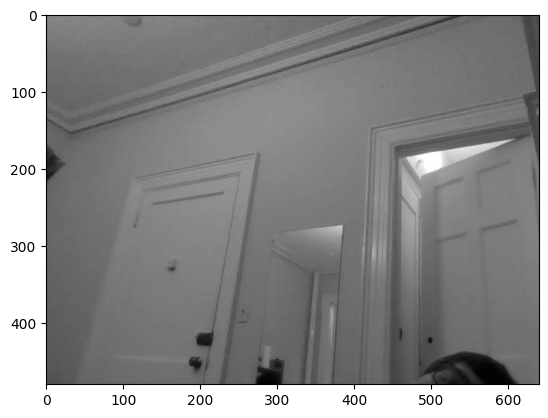

In [130]:
success, frame = webcam.read()
if success:
    grayscale = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    plt.imshow(grayscale, cmap='gray')
    plt.plot()

In [131]:
def rescaleFrame(frame: Mat | ndarray[Any, dtype[generic]] | ndarray, scale) -> UMat:
    height = int(frame.shape[0] * scale)
    width = int(frame.shape[1] * scale)
    return cv.resize(frame, (width, height), interpolation=cv.INTER_AREA)

In [132]:
def setResLiveVideo(frame: VideoCapture, width: int):
    # given the width we automatically figure out the height
    scale = width / frame.get(3)
    height = int(frame.get(4) * scale)
    webcam.set(3, width)
    webcam.set(4, height)

In [133]:
# rescale frame for faster computation
setResLiveVideo(webcam, 400)

In [134]:
def calc_area(img: np.ndarray):
    return np.count_nonzero(img)

In [135]:
def find_centroid(img: np.ndarray):
    area = calc_area(img)
    # calculate the first moment
    m10 = 0
    m01 = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] > 0:
                m10 += i
                m01 += j
    # calculate the centroid
    x = m10 / area
    y = m01 / area
    # draw a dot at the centroid
    img = cv.circle(img, (int(y), int(x)), 5, (0, 255, 0), -1)
    return (x, y)

In [136]:
def find_axis_of_least_inertia(img: np.ndarray):
    # calc first moments
    x, y = find_centroid(img)
    # calculate the second moments
    m11 = 0
    m20 = 0
    m02 = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] > 0:
                m11 += (i - x) * (j - y)
                m20 += (i - x) ** 2
                m02 += (j - y) ** 2
    # calculate the angle of least inertia
    theta = 0.5 * np.arctan2(2 * m11, m20 - m02)
    # draw the angle line with midpoint at centroid
    x1 = int(x + 100 * np.cos(theta))
    y1 = int(y + 100 * np.sin(theta))
    x2 = int(x - 100 * np.cos(theta))
    y2 = int(y - 100 * np.sin(theta))

    img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    img = cv.line(img, (y1, x1), (y2, x2), (0, 255, 0), 2)
    cv.putText(img, f'{theta}', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv.LINE_AA)
    cv.imshow("Angle of Least Inertia", img)

    # rotate such that the line of least inertia is horizontally flat
    (rows, cols, _) = img.shape
    M = cv.getRotationMatrix2D((cols/2, rows/2), -math.degrees(theta), 1)
    img = cv.warpAffine(img, M, (cols, rows))
    cv.imshow("Post rotation", img)

    print(f'Angle of least inertia: {theta} {math.degrees(theta)}')
    return theta

In [137]:
while True:
    success, frame = webcam.read()
    if not success:
        print('Failed to capture frame')
        break

    cv.imshow("Original", frame)

    # convert the video frame into a binary image
    # so that all pixels that look like skin color
    # are included in the binary object
    # hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    # ycrcb = cv.cvtColor(frame, cv.COLOR_BGR2YCrCb)

    # # Define the thresholds for HSV color space
    # lower_hsv = np.array([0, 15, 0], dtype=np.uint8)
    # upper_hsv = np.array([17, 170, 255], dtype=np.uint8)

    # # Define the thresholds for YCrCb color space
    # lower_ycrcb = np.array([0, 135, 85], dtype=np.uint8)
    # upper_ycrcb = np.array([255, 180, 135], dtype=np.uint8)

    # # Create masks for each color space
    # mask_hsv = cv.inRange(hsv, lower_hsv, upper_hsv)
    # mask_ycrcb = cv.inRange(ycrcb, lower_ycrcb, upper_ycrcb)

    # # Combine the masks
    # mask_combined = cv.bitwise_and(mask_hsv, mask_ycrcb)

    # # Apply the combined mask to the original frame
    # frame_masked = cv.bitwise_and(frame, frame, mask=mask_combined)

    # # Display the masked video
    # cv.imshow("Masked", frame)

    img_HSV = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    #skin color range for hsv color space 
    HSV_mask = cv.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
    HSV_mask = cv.morphologyEx(HSV_mask, cv.MORPH_OPEN, np.ones((3,3), np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv.cvtColor(frame, cv.COLOR_BGR2YCrCb)
    #skin color range for hsv color space 
    YCrCb_mask = cv.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
    YCrCb_mask = cv.morphologyEx(YCrCb_mask, cv.MORPH_OPEN, np.ones((3,3), np.uint8))

    #merge skin detection (YCbCr and hsv)
    global_mask=cv.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv.medianBlur(global_mask,3)
    global_mask = cv.morphologyEx(global_mask, cv.MORPH_OPEN, np.ones((4,4), np.uint8))

    HSV_result = cv.bitwise_not(HSV_mask)
    YCrCb_result = cv.bitwise_not(YCrCb_mask)
    global_result=cv.bitwise_not(global_mask)

    cv.imshow("masked", global_result)

    # smooth out the image via median blur (take the median of surrounding pixels)
    # effective for removing the noise
    frame = cv.medianBlur(frame,13)

    #cv.imshow('Video 1', frame)

    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    _, thres_output = cv.threshold(gray, 20, 255, cv.THRESH_BINARY)

    # find largest object in the binary image
    contours, _ = cv.findContours(thres_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)

    if len(contours) == 0:
        continue

    # draw the largest object
    if len(contours) > 0:
        x, y, w, h = cv.boundingRect(contours[0])
        thres_output = cv.rectangle(thres_output, (x, y), (x+w, y+h), (0, 255, 0), 4)

    # get rid of everything except the largest object
    mask = np.zeros(thres_output.shape, dtype=np.uint8)
    cv.drawContours(mask, contours, 0, (255, 255, 255), -1)
    thres_output = cv.bitwise_and(thres_output, mask)
    # fill holes in the contour
    cv.fillPoly(thres_output, pts =[contours[0]], color=(255,255,255))

    theta = find_axis_of_least_inertia(thres_output)

    #cv.imshow("Video 1", thres_output)

    if cv.waitKey(20) & 0xFF==ord('d'):
        break

Angle of least inertia: -1.5707963230281556 -89.99999978418164
Angle of least inertia: 1.5707831128189604 89.99924289494827
Angle of least inertia: 1.5707592083513824 89.99787326984455
Angle of least inertia: 1.5707688738703296 89.99842706328702
Angle of least inertia: 1.5707629504224752 89.9980876747248
Angle of least inertia: 1.5707724503884595 89.99863198268122
Angle of least inertia: -1.5707963230281556 -89.99999978418164
Angle of least inertia: -1.5707963230281556 -89.99999978418164
Angle of least inertia: -1.5707963230281556 -89.99999978418164
Angle of least inertia: -1.5707963230281556 -89.99999978418164
Angle of least inertia: -1.5707963230281556 -89.99999978418164
Angle of least inertia: -1.5707963230281556 -89.99999978418164
Angle of least inertia: 1.5698149877289278 89.94377341324868
Angle of least inertia: 1.5694377609106256 89.92215990864081
Angle of least inertia: 1.5691293286463297 89.904488041631
Angle of least inertia: 1.569174342340808 89.90706713634489
Angle of least

Traceback (most recent call last):
  File "c:\Users\munir\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\munir\AppData\Local\Temp\ipykernel_14060\194212039.py", line 86, in <module>
    theta = find_axis_of_least_inertia(thres_output)
  File "C:\Users\munir\AppData\Local\Temp\ipykernel_14060\3617560040.py", line -1, in find_axis_of_least_inertia
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\munir\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\munir\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
  File 